In [1]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view as SWV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
PRODUCTS = ['ROSES','STARBERRIES','CHOCOLATE','GIFT_BASKET']

In [6]:
def read_data(data_path: str):
    data_path = Path(f"./{data_path}")
    csv_files = data_path.glob("*.csv")
    data = {}
    price_list = []
    for csv_file in csv_files:
        if 'prices' in str(csv_file):
            price_list.append(pd.read_csv(csv_file, sep=";"))
    data = pd.concat(price_list)
    return data

In [12]:
data = read_data('round-3-island-data-bottle').sort_values(by=['day', 'timestamp'])

In [31]:
data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,CHOCOLATE,7999,111,NaN,NaN,NaN,NaN,8001,111,NaN,NaN,NaN,NaN,8000.0,0.0
1,0,0,STRAWBERRIES,3999,210,NaN,NaN,NaN,NaN,4001,210,NaN,NaN,NaN,NaN,4000.0,0.0
2,0,0,ROSES,14999,72,NaN,NaN,NaN,NaN,15001,72,NaN,NaN,NaN,NaN,15000.0,0.0
3,0,0,GIFT_BASKET,71348,19,71347.0,24.0,NaN,NaN,71362,19,71363.0,24.0,NaN,NaN,71355.0,0.0
4,0,100,GIFT_BASKET,71344,1,71343.0,12.0,71342.0,20.0,71355,1,71356.0,12.0,71357.0,20.0,71349.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2,999800,GIFT_BASKET,69537,2,69536.0,18.0,69535.0,24.0,69547,2,69548.0,18.0,69550.0,24.0,69542.0,0.0
39996,2,999900,CHOCOLATE,7749,143,NaN,NaN,NaN,NaN,7751,143,NaN,NaN,NaN,NaN,7750.0,0.0
39997,2,999900,GIFT_BASKET,69551,1,69550.0,19.0,69549.0,20.0,69561,1,69562.0,19.0,69564.0,20.0,69556.0,0.0
39998,2,999900,STRAWBERRIES,3984,240,NaN,NaN,NaN,NaN,3985,92,3986.0,148.0,NaN,NaN,3984.5,0.0


In [50]:
weights = {
    'CHOCOLATE': 4,
    'STRAWBERRIES': 6,
    'ROSES': 1,
    'GIFT_BASKET': 0
}

In [51]:
data['weighted_price'] = data.apply(lambda x: x['mid_price'] * weights[x['product']], axis=1)

In [54]:
data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,weighted_price
0,0,0,CHOCOLATE,7999,111,NaN,NaN,NaN,NaN,8001,111,NaN,NaN,NaN,NaN,8000.0,0.0,32000.0
1,0,0,STRAWBERRIES,3999,210,NaN,NaN,NaN,NaN,4001,210,NaN,NaN,NaN,NaN,4000.0,0.0,24000.0
2,0,0,ROSES,14999,72,NaN,NaN,NaN,NaN,15001,72,NaN,NaN,NaN,NaN,15000.0,0.0,15000.0
3,0,0,GIFT_BASKET,71348,19,71347.0,24.0,NaN,NaN,71362,19,71363.0,24.0,NaN,NaN,71355.0,0.0,0.0
4,0,100,GIFT_BASKET,71344,1,71343.0,12.0,71342.0,20.0,71355,1,71356.0,12.0,71357.0,20.0,71349.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2,999800,GIFT_BASKET,69537,2,69536.0,18.0,69535.0,24.0,69547,2,69548.0,18.0,69550.0,24.0,69542.0,0.0,0.0
39996,2,999900,CHOCOLATE,7749,143,NaN,NaN,NaN,NaN,7751,143,NaN,NaN,NaN,NaN,7750.0,0.0,31000.0
39997,2,999900,GIFT_BASKET,69551,1,69550.0,19.0,69549.0,20.0,69561,1,69562.0,19.0,69564.0,20.0,69556.0,0.0,0.0
39998,2,999900,STRAWBERRIES,3984,240,NaN,NaN,NaN,NaN,3985,92,3986.0,148.0,NaN,NaN,3984.5,0.0,23907.0


In [57]:
comb = data.groupby(['day', 'timestamp']).sum()['weighted_price'].reset_index(drop=True)

In [46]:
gift = data[data['product'] == 'GIFT_BASKET'].reset_index(drop=True)['mid_price']

In [61]:
errs = comb - gift
print(errs.mean())

-379.4904833333333


In [63]:
from sklearn.preprocessing import StandardScaler

In [78]:
ss = StandardScaler(with_std = False)
serrs = ss.fit_transform(pd.DataFrame(errs)).squeeze()

(array([  66.,  369., 2326., 4047., 7299., 7419., 5199., 1976., 1149.,
         150.]),
 array([-252.50951667, -203.30951667, -154.10951667, -104.90951667,
         -55.70951667,   -6.50951667,   42.69048333,   91.89048333,
         141.09048333,  190.29048333,  239.49048333]),
 <BarContainer object of 10 artists>)

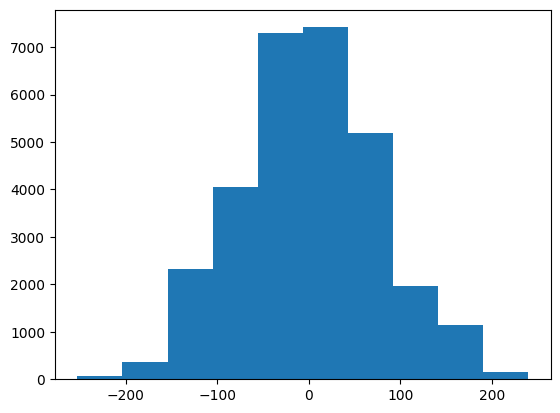

In [80]:
plt.hist(serrs)

In [83]:
max_pnl = float('-inf')
max_cutoff = 0

for cut_off in np.arange(0, 200, 50):
    pnl = np.sum(np.abs(serrs[np.abs(serrs) > cut_off]))
    if pnl > max_pnl:
        max_cutoff = cut_off
        max_pnl = pnl

In [85]:
max_pnl

1824340.4867333334

In [9]:
def find_reg_model(data):
    errors = []
    for REG_DIM in range(5, 31):
        X = SWV(data, REG_DIM)[:-1]
        y = data[REG_DIM:]
        lr_mod = LinearRegression()
        lr_mod.fit(X, y)
        pred = lr_mod.predict(X)
        error = mean_squared_error(y, pred)
        errors.append((error, REG_DIM))
    plt.plot([dim for _, dim in errors], [err for err, _ in errors])
    plt.show()
    errors.sort()
    BEST_DIM = errors[0][1]
    X = SWV(data, BEST_DIM)[:-1]
    y = data[BEST_DIM:]
    lr_mod = LinearRegression()
    lr_mod.fit(X, y)
    pred = lr_mod.predict(X)
    best_error = y-pred
    plt.plot(best_error)
    plt.show()
    return BEST_DIM
    

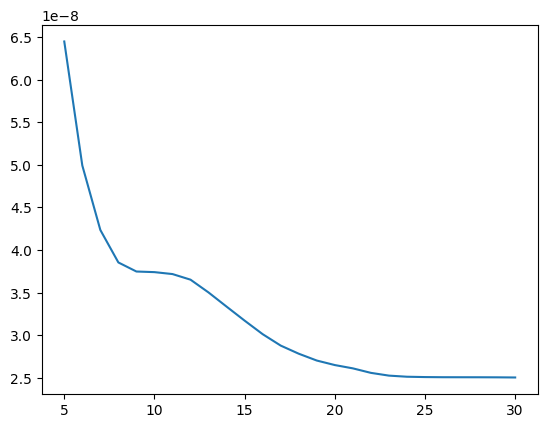

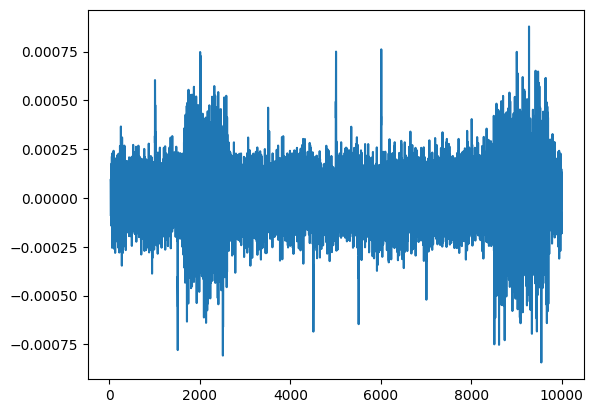

30

In [139]:
find_reg_model(data_dm1.SUNLIGHT)

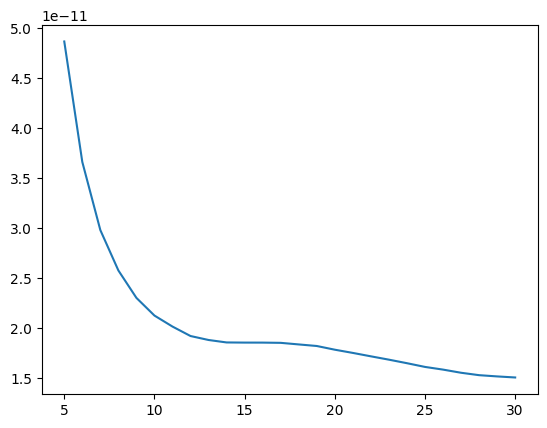

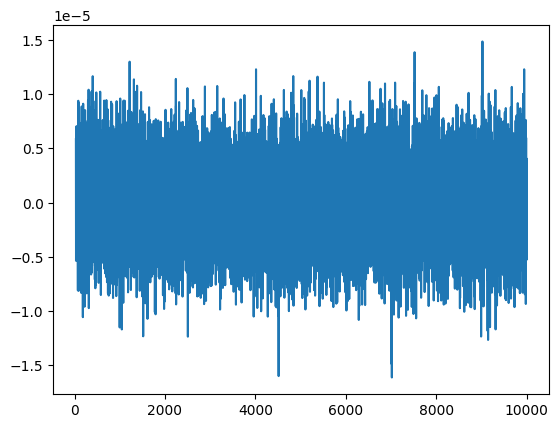

30

In [140]:
find_reg_model(data_dm1.HUMIDITY)

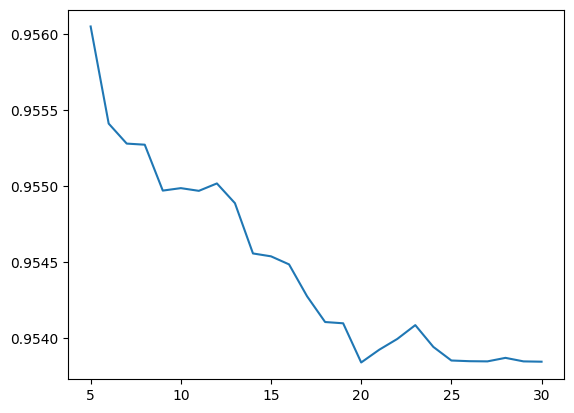

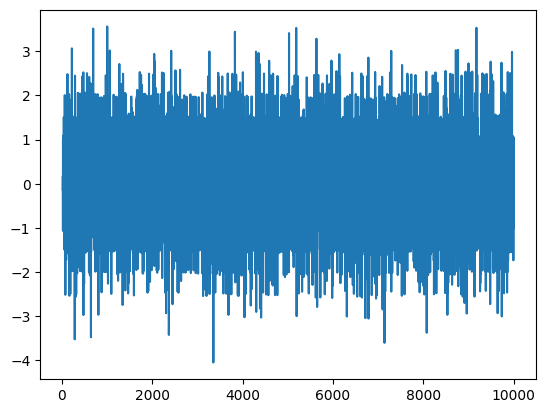

20

In [141]:
find_reg_model(data_dm1.ORCHIDS)

In [51]:
X_list = []
y_list = []
DIM = 20
for i in range(-1,2):
    data_day = data[data.DAY == i]
    X = SWV(data_day.ORCHIDS, DIM)[:-1]
    y = data_day.ORCHIDS[DIM:]
    X_list.append(X)
    y_list.append(y)
X = np.concatenate(X_list)
y = np.concatenate(y_list)

In [41]:
lr_mod = LinearRegression()
lr_mod.fit(X, y)
err_norm = y - lr_mod.predict(X)

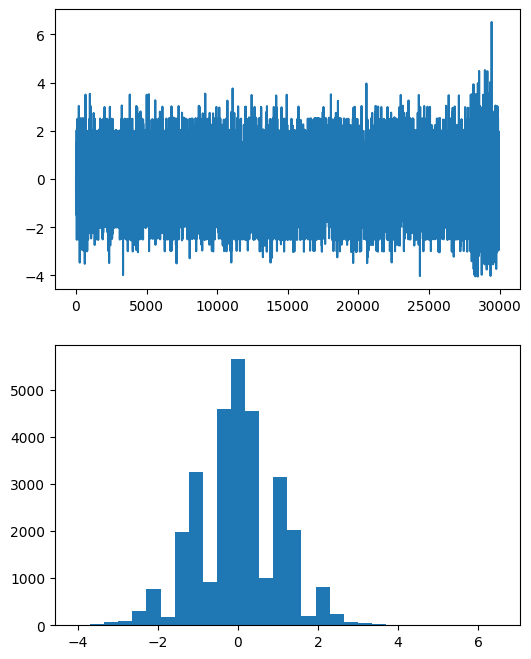

In [45]:
fig, ax = plt.subplots(2,1, figsize=(6,8))
ax[0].plot(err_norm)
ax[1].hist(err_norm, bins=30)
plt.show()

In [135]:
N = len(data_day)
MINS = 12 * 60
HOURS = 12
SUN_AVG = 2500
MIN_HOURS = 7

In [136]:
def sunlight_to_var(sunlight_sum):
    return sunlight_sum/(N/HOURS) > SUN_AVG * MIN_HOURS

In [151]:
X_list = []
for i in range(-1,2):
    data_day = data[data.DAY == i]
    X_orc = SWV(data_day.ORCHIDS, DIM)[:-1]
    X_sun = pd.DataFrame(data_day.SUNLIGHT.expanding().sum())[DIM:]
    X_sun = np.concatenate([X_orc, X_sun], axis=1)
    X_list.append(X_sun)
X_sun = np.concatenate(X_list)

In [152]:
lr_mod = LinearRegression()
lr_mod.fit(X_sun, y)
err_sun = y - lr_mod.predict(X_sun)

In [173]:
def humidity_to_var(humidity):
    if 60 <= humidity <= 80:
        return 100
    return 100-max(humidity-80, 60-humidity)//5*2

In [174]:
X_list = []
for i in range(-1,2):
    data_day = data[data.DAY == i]
    X_orc = SWV(data_day.ORCHIDS, DIM)[:-1]
    X_hum = pd.DataFrame(data_day.HUMIDITY.apply(lambda x: humidity_to_var(x)))[DIM:]
    X_hum = np.concatenate([X_orc, X_hum], axis=1)
    X_list.append(X_hum)
X_hum = np.concatenate(X_list)

In [175]:
lr_mod = LinearRegression()
lr_mod.fit(X_hum, y)
err_hum = y - lr_mod.predict(X_hum)

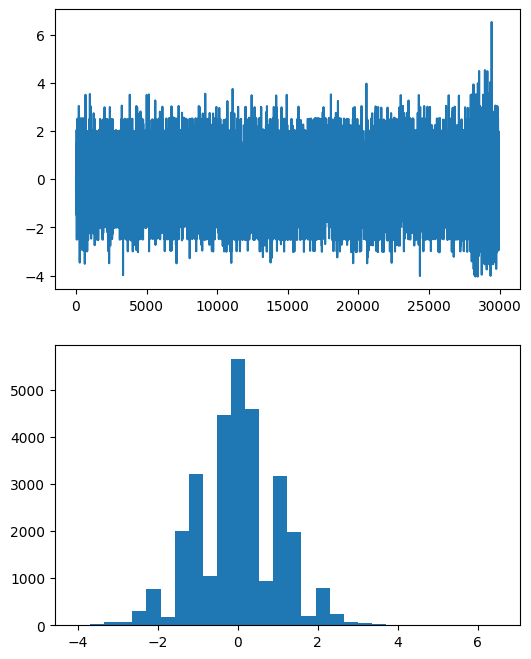

In [96]:
fig, ax = plt.subplots(2,1, figsize=(6,8))
ax[0].plot(err_hum)
ax[1].hist(err_hum, bins=30)
plt.show()

In [176]:
print(lr_mod.intercept_, lr_mod.coef_)

0.5529136448478766 [-2.10434807e-03 -5.42746759e-03  8.87177642e-03 -6.40110869e-03
  5.77493886e-03 -5.94693972e-04 -5.01163871e-03 -3.23051743e-03
  1.59362230e-02 -5.45898258e-03 -2.94750033e-03 -5.76994740e-03
  9.26883850e-04  1.97981622e-03  1.69280738e-02 -8.55105816e-03
 -7.62958119e-03  1.00749032e-02 -1.24811554e-02  1.00505265e+00
 -4.93967959e-03]


In [153]:
X_list = []
for i in range(-1,2):
    data_day = data[data.DAY == i]
    X_orc = SWV(data_day.ORCHIDS, DIM)[:-1]
    X_sun = pd.DataFrame(data_day.SUNLIGHT.expanding().sum())[DIM:]
    X_hum = pd.DataFrame(data_day.HUMIDITY.apply(lambda x: humidity_to_var(x)))[DIM:]
    X_tot = np.concatenate([X_orc, X_sun, X_hum], axis=1)
    X_list.append(X_tot)
X_tot = np.concatenate(X_list)

In [154]:
lr_mod = LinearRegression()
lr_mod.fit(X_tot, y)
err_tot = y - lr_mod.predict(X_tot)

In [172]:
print(err_norm.sum(), err_sun.sum(), err_hum.sum(), err_tot.sum())

9.459085958951619e-09 4.840330802835524e-09 1.950866135302931e-10 8.573238119424786e-09


In [170]:
err_hum

array([ 0.02085422,  0.00244214,  0.25181547, ...,  0.01256917,
       -1.99944295,  1.0189088 ])